In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from numba import jit

### Introdução
A atividade a ser explorada neste trabalho diz respeito ao processo de termalização. Aqui será apresentada uma simulação do modelo de Ising 2D com base no algoritmo de Metropolis. 
O modelo de Ising 2D pode ser entendido como um grid de pontos, no qual cada ponto representa um spin, isto é, um momento magnético. Cada spin pode assumir dois valores: +1 ou -1. O modelo de Ising 2D é um modelo de mecânica estatística que descreve a interação entre spins vizinhos.

In [2]:
def initial_system_config(N):
    """
    Define a configuração inicial do sistema aleatoriamente 
    S é um array unidimensional que recebe valores aleatórios -1 ou 1 em cada uma de suas posições
    """
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

Para fins de otimização, optou-se por representar o grid do modelo de ising como um array unidemensional. Para isso, foi necessário criar uma função que mapeia a posição de um spin no grid para a posição correspondente no array. Essa função é apresentada abaixo.

In [3]:
@jit(nopython=True)
def vizinhos(N):
    """
    Define a tabela de vizinhos
    """
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

In [4]:
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [5]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

In [6]:
def metroplis_ising(N, T, mc_steps):    
# Passos gerais do algoritmo
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    magnetizations = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))   
        magnetizations.append(np.sum(S)) 
    
    return energy_system, magnetizations

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

As duas funções abaixo são usadas para plotar tanto os estados de energia quanto a magnetização do sistema. O eixo y representa a energia ou a magnetização, enquanto o eixo x representa o número de iterações (passos de Monte Carlo).

In [7]:
def _plot(values, mc_steps, N, T, xlabel='Monte Carlo Step', ylabel='Energy', title='Energy vs MC steps'):
    for value in values:
        plt.plot(mc_steps, value)

    title = f'{title} (N={N}, T={T})'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [8]:
def plot_systems_energy(systems, magnetizations, N, T, mc_steps=1000):
    mc_steps = np.arange(0, mc_steps, 1)
    _plot(systems, mc_steps, N, T)
    _plot(magnetizations, mc_steps, N, T, ylabel='Magnetization', title='Magnetization vs MC steps')

Abaixo encontram-se as funções que manejam o algoritmo de Metropolis. Elas recebem como parâmetros o estado inicial do sistema, o número de iterações (passos de Monte Carlo) e a temperatura. Ela retorna o número de spins, temperatura, energia e magnetização definidos para o sistema a partir da chamada de metropolis_ising. Os dois últimos encontram-se em listas, nas quais cada uma das posições dizem respeito ao estado do sistema após um passo de monte carlo.

Aqui optou-se por permitir ao usuário que escolha entre a configuração padrão - definida pelo enunciado da atividade - ou uma configuração aleatória. O controlador disso é o parâmetro standard, que por padrão é True, definindo 1024 spins e temperatura = 1.5. Caso o usuário queira uma configuração aleatória, basta passar o parâmetro como False e então serão gerados N e T em um intervalo definido T = [0.4, 3] real  e N = [20, 100] inteiro.

In [9]:
def generate_systems(N=1024, T=1.5, n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios ou padrões. \n
    No caso de padrões  a temperatura é fixa em 1.5 e o tamanho do sistema em 1024 spins.
    """
    energies = []
    magnetizations = []
    
    T = 1.5
    N = 1024

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [10]:
def generate_random_systems(N_range=[], T_range=[],  n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios \n
    No caso de aleatórios a temperatura e o tamanho do sistema são gerados aleatoriamente
    dentro dos intervalos definidos por T_range e N_range, respectivamente, que são listas de dois valores.
    """
    energies = []
    magnetizations = []
    
    T = np.random.uniform(T_range[0], T_range[1])
    N = np.random.randint(N_range[0], N_range[1]) ** 2

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

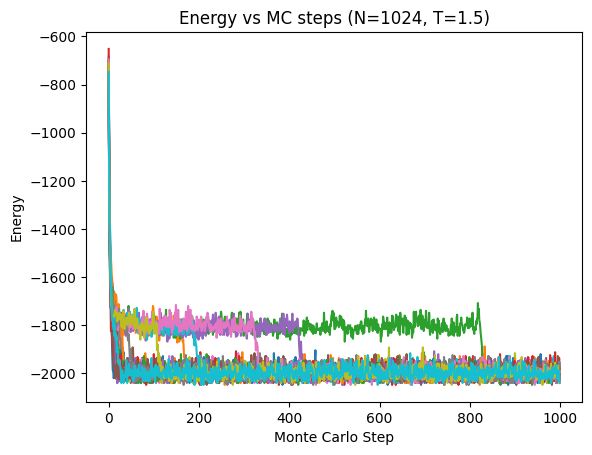

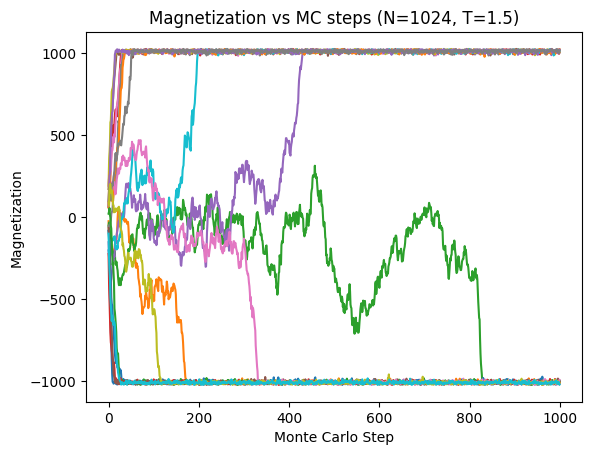

In [11]:
systems, magnetizations, N, T = generate_systems([20, 100], [0.4, 3], n_systems=20)
plot_systems_energy(systems, magnetizations, N, T)